In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
pwd

'/home/lleon/Desktop/LARC2018/FeatureMatching-Homography'

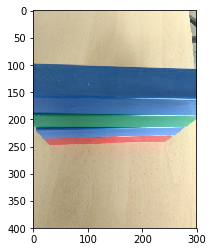

In [20]:
#image = cv2.imread('/home/lleon/Pictures/Webcam/2018-08-28-202524.jpg')
image = cv2.imread('containers1.jpg')
image = cv2.resize(image,(300,400)) # Opencv BGR
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # hsv image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
# BGR limites
red_boundary = ([0, 100, 80], [10, 255, 220])
green_boundary = ([25, 40, 50], [70, 180, 180])
blue_boundary = ([100, 20, 20], [170, 255, 160])
boundaries = [red_boundary, green_boundary, blue_boundary]

masks = []

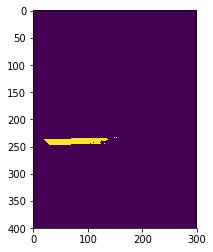

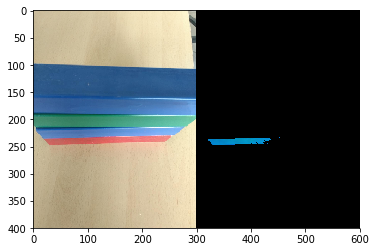

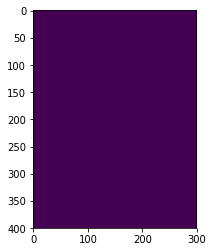

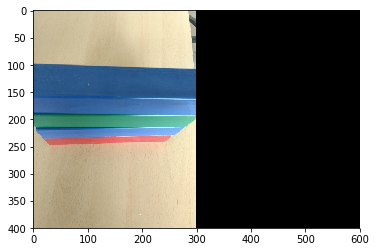

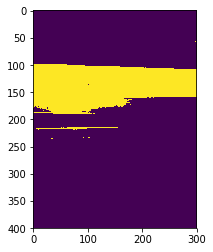

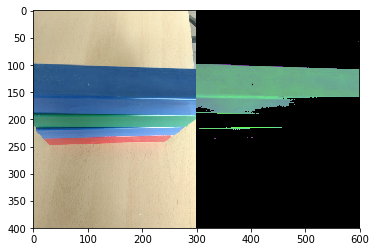

In [22]:
for (lower, upper) in boundaries:
    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")
    
    mask = cv2.inRange(hsv_image, lower, upper)
    masks.append(mask)
    output = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)
    plt.imshow(mask)
    plt.show()
    plt.imshow(np.hstack([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), output]))
    plt.show()

In [23]:
print(masks[0][231, 253])

0


In [7]:
# Negro = 0
# Red   = 1
# Green = 2
# Blue  = 3
dic_color = {0: "Black", 1: "Red", 2: "Green", 3: "Blue"}

In [8]:
print(masks[0].shape)

(400, 300)


In [9]:
%%time
th = 150 * 255
mask1D = np.zeros(400)
mask2D = np.sum(masks, axis=2)
for i in range(400):
    for idx in range(3):
        if mask2D[idx, i] >= th:
            mask1D[i] = idx+1

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.34 ms


In [10]:
rpta = []
rpta.append(0)
for i in range(1, 400):
    if mask1D[i] != 0 and rpta[-1] != mask1D[i]:
        rpta.append(mask1D[i])
rpta.append(0)
rpta

[0, 1.0, 3.0, 2.0, 3.0, 0]

In [11]:
# Resultados
for i in rpta:
    print(dic_color[i])

Black
Red
Blue
Green
Blue
Black


In [12]:
def pipeline(hsv_image):
    red_boundary = ([0, 20, 100], [10, 255, 255])
    green_boundary = ([40, 20, 100], [90, 255, 255])
    blue_boundary = ([100, 20, 20], [170, 255, 160])
    boundaries = [red_boundary, green_boundary, blue_boundary]

    masks = []
    
    for (lower, upper) in boundaries:
        lower = np.array(lower, dtype="uint8")
        upper = np.array(upper, dtype="uint8")

        mask = cv2.inRange(hsv_image, lower, upper)
        masks.append(mask)

    
    dic_color = {0: 'Black', 1: 'Red', 2: 'Green', 3: 'Blue'}
    
    th = 150 * 255
    mask1D = np.zeros(400)
    mask2D = np.sum(masks, axis=2)
    for i in range(400):
        for idx in range(3):
            if mask2D[idx, i] >= th:
                mask1D[i] = idx+1
    rpta = []
    rpta.append(0)
    for i in range(1, 400):
        if mask1D[i] != 0 and rpta[-1] != mask1D[i]:
            rpta.append(mask1D[i])
    rpta.append(0)
    
    for i, x in enumerate(rpta):
        rpta[i] = dic_color[x]
    
    return rpta

# Pruebas con camaras

In [19]:
import cv2
import numpy as np

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,20)
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 2


def show_webcam(mirror=False):
    cam = cv2.VideoCapture(0)
    #cam.set(10,25)
    #cam.set(11,130)
    #cam.set(14,31)
    
    while True:
        ret_val, img = cam.read()
        #if mirror: 
        #    img = cv2.flip(img, 1)
        image = cv2.resize(img,(300,400)) # Opencv BGR
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        text = pipeline(hsv_image)
        string = ""
        for x in text:
            string += (x + '\n')
        #print(string)
        #print(type(string))
        cv2.putText(img, string, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
        cv2.imshow('my webcam', img)
        if cv2.waitKey(1) == 27: 
            break  # esc to quit
    cv2.destroyAllWindows()


def main():
    show_webcam(mirror=True)


if __name__ == '__main__':
    main()
    


# Shape detector

In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
class ShapeDetector:
    def __init__(self):
        pass
    
    def detect(self, c):
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        if len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            
            shape = "Square" if ar >= 0.95 and ar <= 1.05 else "Rectangle"
        
        elif len(approx) == 5:
            shape = "Pentagon"
            
        else:
            shape = "Circle"
            
        return shape

In [3]:
t1 = time.time()
image = cv2.imread("images/containers1.jpg")
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])

# convert the resized image to grayscale, blur it slightly,
# and threshold it
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

# find contours in the thresholded image and initialize the
# shape detector
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
sd = ShapeDetector()

for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape = sd.detect(c)

    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    # show the output image
print(time.time() - t1)
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.21367979049682617


In [4]:
# Convert BGR to HSV
frame = cv2.imread("images/containers1.jpg")
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(frame,frame, mask= mask)

cv2.imshow('frame',frame)
cv2.imshow('mask',mask)
cv2.imshow('res',res)
cv2.waitKey(0)
cv2.destroyAllWindows()

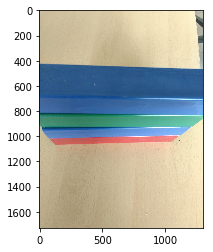

In [5]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(hsv)
plt.show()